In [1]:
from torchvision import datasets, transforms 
data_path = './datasets/'
cifar10 = datasets.CIFAR10(root = data_path, download=True, train=True)
cifar10_val = datasets.CIFAR10(root = data_path, download=True, train=False)

In [2]:
# Print the method resolution order of our dataset instance. 
# Notice that the dataset is returned as a subclass of torch.utils.data.dataset.Dataset base class. 
type(cifar10).__mro__, cifar10.__repr__()

((torchvision.datasets.cifar.CIFAR10,
  torchvision.datasets.vision.VisionDataset,
  torch.utils.data.dataset.Dataset,
  typing.Generic,
  object),
 'Dataset CIFAR10\n    Number of datapoints: 50000\n    Root location: ./datasets/\n    Split: Train')

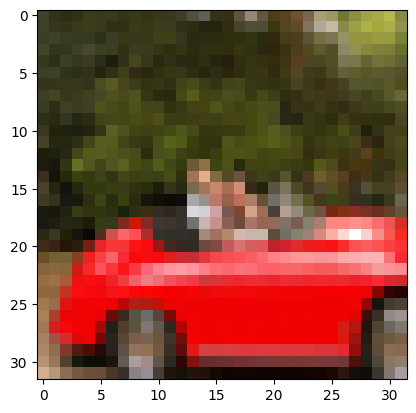

In [3]:
# plot one of the images 
import matplotlib.pyplot as plt 

img, label = cifar10[99]
plt.imshow(img)
plt.show()

In [4]:
class_names = cifar10.classes
class_names[label]

'automobile'

### Transform image data on instantiation 

Now let's use the `transforms` module from torchvision to convert these PIL images to PyTorch tensors. 

- This module defines a set of composable function-like objects that can be passed as an argument to a torchvision dataset upon instantiation, and they perform transformations on the data after it is loaded but before it is returned by `__getitem__`


In [5]:
from torchvision import transforms 
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [6]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

The image has been turned into a 3x32x32 tensor and therefore a 3-channel (RGB)

In [7]:
# instantiate the dataset with the transform 
tensor_cifar10 = datasets.CIFAR10(root=data_path, train=True, download=False, transform = transforms.ToTensor())

In [8]:
img_t, _ = tensor_cifar10[99]
type(img_t), type(img)

(torch.Tensor, PIL.Image.Image)

In [9]:
img_t.dtype, img_t.shape

(torch.float32, torch.Size([3, 32, 32]))

The `.ToTensor()` transform turns the data into a 32-bit floating-point per channel, scaling the values down to the range `0.0` to `1.0`.

In [10]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

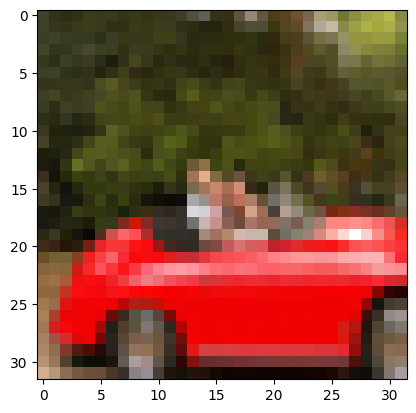

In [11]:
# plotting img_t: a tensor of image data 
plt.imshow(img_t.permute(1,2,0))
plt.show()

Transforms can be chained using `transforms.Compose`. They can handle normalization and data augmentation transparently. 
- Each channel having zero mean and unitary standard deviation. 
- It is good practice to normalize the dataset so that each channel has zero mean and unitary standard deviation. 
    By choosing activation functions that are linear around `0` plus or minus `1`(or`2`), keeping the data in the same range means it's more likely that neurons have nonzero gradients and hence will learn sooner. 
- Also, Normalizing each channel so that it has the same distribution will ensure that channel information can be mixed and update through gradient descent using the same learning rate. 
- `transforms.Normalize` takes mean and stdev as arguments. 


### Normalizing our tensors

In [12]:
# using transforms.Normalize, we can compute the mean value and the standard deviation of each channel across the dataset 
# then apply the following transform: v_n[c] = (v[c] - mean[c]) / stdev[c]
import torch 

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

`3` channels (RGB), with height `32`, width`32`, and `50000` of these (images). 

In [13]:
imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [14]:
transforms.Normalize(mean = (0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [15]:
transformed_cifar10 = datasets.CIFAR10(
    root = data_path, 
    download=False, 
    train=True, 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
    ])
)

Plotting the normalized image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..2.1264887].


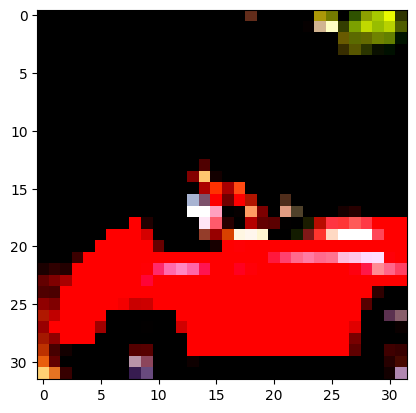

In [16]:
img_t, label = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

### Building the Dataset, testing the model. 

In [17]:
class_names = ['airplane', 'bird']
label_map = {0:0, 2:1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

In [18]:
import torch.nn as nn 
n_out = 2
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

Understanding that the output is categorical (airplane, bird), therefore we should use one-hot-encoding representation. In the ideal case, the network would output `torch.tensor([1.0, 0.0])` for an airplane, `torch.tensor([0.0, 1.0])` for a bird, but since our classifier will not be perfect, we can expect the network to output something in between. **We can interpret our output as probabilities i.e. the first entry is the probability of 'airplane', and the second is the probability of 'bird'.** 
- Each element of the output must be in the `[0.0, 1.0]` range. 
- The elements of the output must add up to 1.0. 

In other words, a probability of an outcome cannot be less than 0 or greater than 1, and we are certain that one of the two outcomes will occur. 

**Softmax** is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints listed above. 

In [19]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [20]:
import torch.nn as nn 
x = torch.tensor([[1.0,2.0,3.0],[1.0,2.0,3.0]])
# in this example, each row is a different input vector
# Apply softmax ALONG the columns. i.e. ALONG dimension 1. 
softmax = nn.Softmax(dim=1)
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

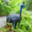

In [21]:
img, _ = cifar2[0]
img

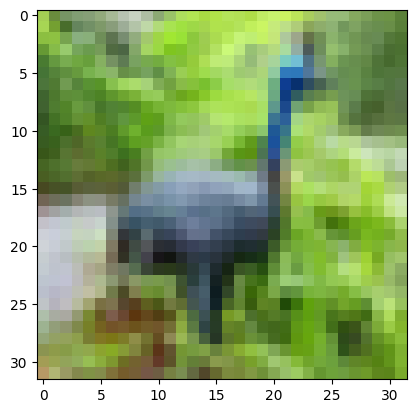

In [22]:
img_t_t = to_tensor(img)
plt.imshow(img_t_t.permute(1,2,0))
plt.show()

Note, our model expects 3072 features (3x32x32) in the input. Also, `nn` works with data organized into batches. So after we obtain a 1d tensor of length 3072, unsqueeze it to produce a batch dimension. 

In [23]:
# test the model 
img_batch = img_t_t.view(-1).unsqueeze(0)
img_batch.size()


torch.Size([1, 3072])

In [28]:
out = model(img_batch)
out

tensor([[0.5658, 0.4342]], grad_fn=<SoftmaxBackward0>)

The output is meaningless, because the weights and biases for our linear layers have not been trained. Their elements are initialized randomly by PyTorch between -1.0 and 1.0. 

Furthermore, the model is not aware of which output probability is which. The loss function associates meaning with these two numbers after backpropogation, and since the loss function was not run, there is no meaning. 

### Loss Function for Classification 

After training, we will be able to get the label as an index by computing the argmax of the output probabilities. That is, the index at which we get the maximum probability. 

In [26]:
torch.max(out, dim=1)
# index

torch.return_types.max(
values=tensor([0.5658], grad_fn=<MaxBackward0>),
indices=tensor([0]))

We will be using the Negative Log Likelihood loss function, conveniently provided in the `nn` module. 

- We want to maximize the probability associated with the correct class (likelihood). Note that we are interested in ensuring that the correct classes probility is higher than the others (Winning the softmax ranking). We are **not** interested in driving this probability to 1 (like MSE). 

- In the following example, we have two predictions from our model, in which the correct classification of the input is associated with the second index of the output. 

    - If we have [0.40, 0.60] we want to maximize the likelihood of the model parameters
    - If we have [0.60, 0.40] we want to maximize that likelihood of the model parameters

    - In the first example, the likelihood (probability associated with the correct class) is larger than the likelihood of the first index, therefore, we want a low loss (penalty) for this correct classification. 
    - In the second example, the likelihood (probabilty associated with the correct class) of the second index is lower than the likelihood of the first index. Therefore, we want high loss to correct this misclassification. 

- From a loss perspective, we want to minimize the negative log-likelihood. 



- Our input to the loss function needs to be a tensor of log probabilities. 
    - Therefore we should use `nn.LogSoftmax`
        - Softmax providing us with the probabilities, 
        - Log providing us with a numerically stable Logarithm of these probabilities. 



In [33]:
# Let's reqrite the model 
import torch.nn as nn 
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
loss = nn.NLLLoss()
img, label = cifar2[0]
img = to_tensor(img)
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))


tensor(0.7045, grad_fn=<NllLossBackward0>)

Note, we are introducing randomness in our gradient descent by estimating the gradient on a few samples at a time. We are working on small batches of shuffled data. It turns out that following gradients estimated over minibatches, which are poorer approximations of gradients estimated across the whole dataset, helps convergence and prevents the optimization process from getting stuck in local minima it encounters along the way. 

Since gradients estimated over minibatches are poorer approximations of gradients estimated across the whole dataset, we want to use a reasonably small learning rate. 

Shuffling the data at each epoch is an attempt to help ensure that the sequence of gradients (from the minibatch) is representative of the whole dataset. 

Minibatches are typically a constant size that we need to set prior to training, just like the learning rate. (hyperparameters)

Below we choose minibatches of size 1. We can use the `Dataloader` module from `torch.utils.data.DataLoader` to help with shuffling and organizing the data into minibatches. 

`DataLoader` provides with a range of different sampling strategies. 

In [ ]:
import torch.optim as optim
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), learning_rate=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100 

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {float(loss)}")